# Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
# from statsFuncs import mean_confidence_interval
# from statsFuncs import compDistributions
import scipy
import random
import math 
from scipy import stats
mpl.rcParams['axes.linewidth'] = 2

import numpy as np
from scipy.integrate import cumtrapz
from scipy.stats import norm
from matplotlib import pyplot as plt


# Paths 

In [2]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
# datapath = figures_path + '/data/radiologists/Analysis5_22_2020/'
datapath = figures_path + '/data/radiologists/Analysis9_29_2020/rbf_back/'

# Plot params 

In [3]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject params 

In [4]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

134 files, 16 folders
15 subjects


In [5]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15']

# Plot histograms 

In [ ]:
df_percentiles = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])
alldata = pd.DataFrame()

row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.add_subplot(111, frameon=False)

axs = axs.ravel()
subject_names_wsuper = subject_names[:-1]
for subject in subject_names_wsuper:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    df_percentiles.loc[row,'SUBJECT'] = subject
    alldata[subject] = subjectdata['responseError']

    axs[row].hist(subjectdata['responseError'])
    axs[row].set_xlabel('')
    axs[row].set_ylabel('')
    axs[row].set_xlim([-60, 60])
    axs[row].set_title(subject)

    row += 1
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Error magnitude')
plt.ylabel('Count')
plt.title('Radiologists\n\n')

## Subject loop with new JND

In [ ]:
n_bins=50

In [ ]:
def calculate_and_plot_cdf(data, title):
    counts, bin_edges = np.histogram (data, bins=n_bins, normed=True)
    cdf = np.cumsum (counts)
    cdf_values = data.value_counts().sort_index().cumsum() / data.shape[0]
    print(cdf_values)
    cdf_percentile_25 = np.percentile(np.sort(cdf_values.index), 25) 
    cdf_percentile_75 = np.percentile(np.sort(cdf_values.index), 75) 
    
    fig,ax = plt.subplots()
    ax.hist(data, alpha=0.5, bins=50, color='lightblue')
    ax.set_xlim([-73, 73])
    ax.set_ylabel('Frequency Histogram')
    ax.vlines(cdf_percentile_25, 0, 25, color='red')
    ax.vlines(cdf_percentile_75, 0, 25, color='green')

    ax2=ax.twinx()


    ax2.plot (bin_edges[1:], cdf/cdf[-1], color='black', linewidth=2.5)
    ax2.set_title('histogram + CDF of response error\n Subject: ' + title)
    ax2.set_xlim([-73, 73])
    ax2.set_ylabel('CDF')
    plt.xlabel('Respose Error')
    plt.show()
#     print(bin_edges)
#     print(cdf_values.index)
    return cdf_values, cdf_percentile_25, cdf_percentile_75

In [ ]:
cdf_data = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    cdf, cdf_percentile_25, cdf_percentile_75 = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_CR'] = (cdf_percentile_75- cdf_percentile_25)/2
    
    
    row += 1

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CR'], color='gray')
plt.ylabel('JND_CR')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) per subject')

In [ ]:
cdf.index

## Steeper function 

In [ ]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

def calculate_and_plot_cdf(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    counts_filtered = counts.copy()
    counts_filtered[counts_filtered < 5] = 0
    cdf_filtered = np.cumsum (counts_filtered)
    c = cdf_filtered.copy()
    cdf_filtered = cdf_filtered/cdf_filtered[-1]
    
    cdf = np.cumsum (counts)
    cdf = cdf/cdf[-1]
    
    bestvals, temp = curve_fit(sigmoid,bin_edges[1:],cdf_filtered,p0=[3])

    perc_25 = inverse_sigmoid(0.25, bestvals)
    perc_75 = inverse_sigmoid(0.75, bestvals)
    
    plt.plot(bin_edges[1:], cdf, color='red', linewidth=1.5, label='original')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals), color='blue', linewidth=2.5,label='filtered')
    plt.xlim([-60, 40])
    plt.ylabel('CDF')
    plt.xlabel('Response Error')
    plt.legend()
    plt.title(title)
    plt.show()
    
    return (perc_75 - perc_25)/2
#     ax2.plot (bin_edges[1:], cdf/cdf[-1], color='black', linewidth=2.5)
#     ax2.set_title('histogram + CDF of response error\n Subject: ' + title)
#     ax2.set_xlim([-73, 73])
#     ax2.set_ylabel('CDF')
#     plt.xlabel('Respose Error')
#     plt.show()
# #     print(bin_edges)
# #     print(cdf_values.index)
#     return cdf_values, cdf_percentile_25, cdf_percentile_75

In [ ]:
cdf_data = pd.DataFrame(columns=['SUBJECT','JND_CR'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

#     cdf_filtered_sub = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    
    jnd_cr = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_CR'] = jnd_cr[0]
    
    
    row += 1

In [ ]:
cdf_data

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CR'], color='gray')
plt.ylabel('JND_CR')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) v2 per subject')

# Gaussian & Cauchy distribution 

## Define functions 

In [ ]:
# data = np.asarray(alldata['S1'])
# counts, bin_edges = np.histogram(data, bins=n_bins)

In [ ]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

# def sigmoid(x,a):
#     return 1/(1+np.exp(-a*x)) + 0

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x-mean)**2/(2*stddev**2))

def gaussian_original(x, amplitude, mean, stddev):
    return amplitude * ((1/(stddev*np.sqrt(2*np.pi))) * np.exp((-1/2)*(((x-mean)**2)/(stddev**2))))

def cauchy(x, gamma, amplitude, mean):
    return (1/(np.pi*gamma*(1+((x-mean)/gamma)**2)))*amplitude

def vm(x, mean, kai, amplitude):
    x = (x/53)*np.pi
    return amplitude * (np.exp(kai * np.cos(x-mean)) / (i0(kai) * 2 * np.pi))
                  
def cdf(counts):
    cdf = np.cumsum (counts)
    cdf = cdf/cdf[-1]
    
    counts_filtered = counts.copy()
    
    counts_filtered[counts_filtered < 5] = 0
    cdf_filtered = np.cumsum (counts_filtered)
    c = cdf_filtered.copy()
    cdf_filtered = cdf_filtered/cdf_filtered[-1]
    

        
    
    return cdf, cdf_filtered, counts_filtered
    
def cdf_gaussian_cauchy(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    
    if title=='SuperSubject':
        counts = counts/13
    
    cdf_og, cdf_filtered_og, counts_filtered_og = cdf(counts)
    
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    
    counts_cauchy = cauchy(bin_edges[1:], *popt_cauchy)
#     print(popt_gaussian)
    counts_gaussian = gaussian(bin_edges[1:], *popt_gaussian)
    counts_vm = vm(bin_edges[1:,], *popt_vm)
    
    cdf_cauchy, cdf_filtered_cauchy, counts_cauchy_filtered = cdf(counts_cauchy)
    cdf_gaussian, cdf_filtered_gaussian, counts_gaussian_filtered = cdf(counts_gaussian)
    cdf_vm, cdf_filtered_vm, counts_vm_filtered = cdf(counts_vm)
    
    
    bestvals_og, temp_og = curve_fit(sigmoid,bin_edges[1:],cdf_og,p0=[3])
    bestvals_cauchy, temp_cauchy = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_cauchy,p0=[3])
    bestvals_gaussian, temp_gaussian = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_gaussian,p0=[3])
    bestvals_vm, temp_vm = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_vm,p0=[3])
    print(bestvals_vm)
    print(bin_edges[1:])
    print(cdf_filtered_vm)
    
    perc_25_og = inverse_sigmoid(0.25, bestvals_og)
    perc_75_og = inverse_sigmoid(0.75, bestvals_og)
        
    perc_25_cauchy = inverse_sigmoid(0.25, bestvals_cauchy)
    perc_75_cauchy = inverse_sigmoid(0.75, bestvals_cauchy)
    
    perc_25_gaussian = inverse_sigmoid(0.25, bestvals_gaussian)
    perc_75_gaussian = inverse_sigmoid(0.75, bestvals_gaussian)

    perc_25_vm = inverse_sigmoid(0.25, bestvals_vm)
    perc_75_vm = inverse_sigmoid(0.75, bestvals_vm)    
    
    plt.plot(bin_edges[1:], cdf_og, color='red', linewidth=1.5, label='original')
#     plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_og), color='red', linewidth=1.5, label='original')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_cauchy), color='blue', linewidth=2.5,label='cauchy')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_gaussian), color='green', linewidth=2.5,label='gaussian')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_vm), color='purple', linewidth=2.5,label='vm')
    
    plt.xlim([-60, 40])
    plt.ylabel('CDF')
    plt.xlabel('Response Error')
    plt.legend()
    plt.title(title)
    plt.show()
    
    return (perc_75_og - perc_25_og)/2, (perc_75_gaussian - perc_25_gaussian)/2, (perc_75_cauchy - perc_25_cauchy)/2, (perc_75_vm - perc_25_vm)/2


In [ ]:
cdf_data = pd.DataFrame(columns=['SUBJECT','JND_OG',  'JND_GAUSSIAN', 'JND_CAUCHY'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    jnd_og, jnd_gaussian, jnd_cauchy, jnd_vm = cdf_gaussian_cauchy(subjectdata['responseError'], title=subject)
    
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_OG'] = jnd_og[0]
    cdf_data.loc[row, 'JND_GAUSSIAN'] = jnd_gaussian[0]
    cdf_data.loc[row, 'JND_CAUCHY'] = jnd_cauchy[0]
    cdf_data.loc[row, 'JND_VM'] = jnd_vm[0]
    
    row += 1

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CAUCHY'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Cauchy Fit')
plt.ylim([0, 7])

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_GAUSSIAN'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Gaussian Fit')
plt.ylim([0, 7])

In [ ]:
np.median(cdf_data['JND_VM'])

In [ ]:
np.median(cdf_data['JND_CAUCHY'])

In [ ]:
np.median(cdf_data['JND_GAUSSIAN'])

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_VM'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n VM Fit')
plt.ylim([0, 7])

In [ ]:
good_cdf_data = cdf_data.copy()
good_cdf_data.loc[13, 'SUBJECT'] = 'mean'
good_cdf_data.loc[13, 'JND_OG'] = np.mean(good_cdf_data.loc[range(13), 'JND_OG'])
good_cdf_data.loc[13, 'JND_GAUSSIAN'] = np.mean(good_cdf_data.loc[range(13), 'JND_GAUSSIAN'])
good_cdf_data.loc[13, 'JND_CAUCHY'] = np.mean(good_cdf_data.loc[range(13), 'JND_CAUCHY'])
good_cdf_data.loc[13, 'JND_VM'] = np.mean(good_cdf_data.loc[range(13), 'JND_VM'])
good_cdf_data

In [ ]:
jnd_vm_sem = stats.sem(good_cdf_data.loc[range(13), 'JND_VM'])
jnd_vm_sem

In [ ]:
jnd_vm_sem_all = [0]*13
jnd_vm_sem_all.append(jnd_vm_sem)
jnd_vm_sem_all

In [ ]:
plt.figure(figsize=(13, 5))
ax = plt.bar(good_cdf_data['SUBJECT'], good_cdf_data['JND_VM'], color='lightgrey', yerr=jnd_vm_sem_all)
plt.ylabel('CRD')
plt.xticks(range(14), ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'Mean'])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Radiologists')
# # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # Only show ticks on the left and bottom spines
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom');


## Goodness of fit 

Here, yi refers to your input y-values, fi refers to your fitted y-values, and ̅y refers to the mean input y-value.

In [ ]:
# residual sum of squares
def r2(x, y,  y_fit, title):
#     weight_param = 1/(abs(x)+1)
#     plt.plot((y - y_fit) ** 2)
#     plt.ylim([0, 2500])
#     plt.title(title)
#     plt.show()
    ss_res = np.sum(((y - y_fit) ** 2))
    
    # total sum of squares
    ss_tot = np.sum(((y - np.mean(y)) ** 2))

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def calculate_r2_subjects(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    
    counts_cauchy = cauchy(bin_edges[1:], *popt_cauchy)
    counts_gaussian = gaussian(bin_edges[1:], *popt_gaussian)
    counts_vm = vm(bin_edges[1:], *popt_vm)

    r2_fit_gaussian = r2(bin_edges[1:], counts, counts_cauchy, title+'Gaussian')
    r2_fit_cauchy = r2(bin_edges[1:], counts, counts_gaussian, title+'Cauchy')
    r2_fit_vm = r2(bin_edges[1:], counts, counts_vm, title+'VM')
    
    
    return r2_fit_gaussian, r2_fit_cauchy, r2_fit_vm

In [ ]:
r2_data = pd.DataFrame(columns=['SUBJECT','R2_GAUSSIAN', 'R2_CAUCHY', 'R2_VM'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    r2_fit_gaussian, r2_fit_cauchy, r2_fit_vm= calculate_r2_subjects(subjectdata['responseError'], subject)
    
    r2_data.loc[row,'SUBJECT'] = subject
    r2_data.loc[row, 'R2_GAUSSIAN'] = r2_fit_gaussian
    r2_data.loc[row, 'R2_CAUCHY'] = r2_fit_cauchy
    r2_data.loc[row, 'R2_VM'] = r2_fit_vm
    
    
    row += 1

In [ ]:
r2_data_melted = r2_data.melt(id_vars=['SUBJECT'], value_vars=['R2_GAUSSIAN','R2_CAUCHY', 'R2_VM'])

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x='SUBJECT', y='value', hue='variable', data=r2_data_melted)
plt.ylabel('R2')


## Comparing fits 

In [ ]:
row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.add_subplot(111, frameon=False)

axs = axs.ravel()

for subject in subject_names_wsuper:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    counts, bin_edges = np.histogram(subjectdata['responseError'], bins=n_bins)
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) 
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    axs[row].hist(subjectdata['responseError'], bins=n_bins, alpha=0.3)
    axs[row].plot(bin_edges[1:], cauchy(bin_edges[1:], *popt_cauchy), color='red', label='cauchy')
    axs[row].plot(bin_edges[1:], gaussian(bin_edges[1:], *popt_gaussian), color='green', label='gaussian')
    axs[row].plot(bin_edges[1:], vm(bin_edges[1:], *popt_vm), color='green', label='vm')
    axs[row].set_xlabel('')
    axs[row].set_ylabel('')
    axs[row].set_xlim([-60, 60])
    axs[row].set_title(subject)
    
    if subject == 's15':
        axs[row].legend()
    
    row += 1
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Error magnitude')
plt.ylabel('Count')
plt.title('Radiologists\n\n');
# plt.legend()


# Category boundaries 

## First version

In [ ]:
perc_extreme_df = pd.DataFrame()
for i, subject in enumerate(subject_names_wsuper):
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)].reset_index(drop=True)
#     display(subjectdata)
    
    perc_extreme = np.sum(abs(subjectdata['responseError']) > abs(subjectdata['Stim_diff']))/len(subjectdata)
    perc_extreme_df.loc[i, 'SUBJECT'] = subject
    perc_extreme_df.loc[i,'PERC_EXTREME'] = perc_extreme*100
#     print(perc_extreme)


In [ ]:
perc_extreme_df

In [ ]:
sns.barplot(x='SUBJECT', y='PERC_EXTREME', data=perc_extreme_df)
plt.ylabel('%')

In [ ]:
min(subjectdata['responseError'])

In [ ]:
np.median(perc_extreme_df['PERC_EXTREME'])

## Second version

In [3]:
def vonmise_derivative(xdata, a = 25, kai = 4):
    xdata = xdata / 73 * np.pi
    return - a / (i0(kai) * 2 * np.pi) * exp(kai * cos(xdata)) * kai * sin(xdata) # Derivative of vonmise formula
def getRunningMean(stimuli_diff, filtered_responseError, halfway =74, step = 8):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

def getRegressionLine(x, y, peak):
    stimuli_diff_filtered = []
    filtered_responseError_new = []
    for i in range(len(x)):
        if x[i] < peak + 1 and x[i] > - peak + 1:
            stimuli_diff_filtered.append(x[i])
            filtered_responseError_new.append(y[i])
    coef = np.polyfit(stimuli_diff_filtered,filtered_responseError_new,1)
    poly1d_fn = np.poly1d(coef)
    return poly1d_fn, coef

In [4]:
def category_definition(morph):
    
    if (morph in range(124, 148)) or (morph in range(1, 26)):
        category = 'A'
    elif morph in range(26, 75):
        category = 'B'
    elif morph in range(75, 124):
        category = 'C'
        
    return category

In [5]:
subjectdata = pd.read_csv(datapath + 'SuperSubject' + '/' + 'SuperSubject' + '_VM_output_-1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)].reset_index(drop=True)


subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)

same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)

In [6]:
def amplitude_calc(data, title):
    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, data['Stim_diff'], data['responseError'], p0=init_vals, bounds = ([-60,2],[60,4]))
    #### RUNNING MEAN ####
    RM, xvals = getRunningMean(data['Stim_diff'], data['responseError'], step = 20)

    plt.figure(figsize=(5, 4))
    plt.plot(data['Stim_diff'], data['responseError'], color='dodgerblue', marker='o', linestyle='none', alpha=0.7, markersize=5)
    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in data['Stim_diff']]
    plt.plot(x, y, '-', linewidth = 4, color='k')
    plt.plot(xvals, RM, label = 'Running Mean', color = 'red', linewidth = 3)
    peak_x = (x[np.argmax(y)])
    poly1d_fn, coef = getRegressionLine(x = data['Stim_diff'], y= data['responseError'], peak = peak_x)
    xdata = np.linspace(-peak_x, peak_x, 100)
    plt.plot(xdata, poly1d_fn(xdata), linestyle='--', color='powderblue', linewidth = 4)
    plt.xlim([-73, 73])
    plt.ylim([-60, 60])
    plt.yticks(np.arange(-60, 70, 10))
    # plt.xticks(np.arange(-70, 80, 20))
    plt.xticks([-73, -50, -25, 0, 25, 50, 73])
    sns.despine()
    # print(coef[0], coef[1])
    plt.title('Current and previous\n ' + title)
    plt.ylabel('Response Error\n(morph units)')
    plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.eps', bbox_inches='tight', dpi=1200)
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.jpg', bbox_inches='tight', dpi=1200)
    plt.show()
    
    if x[np.argmax(y)] > 0: 
        amplitude = np.max(y)
    else: 
        amplitude = -np.max(y)
        
        
    return amplitude



/Users/peterren/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/peterren/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


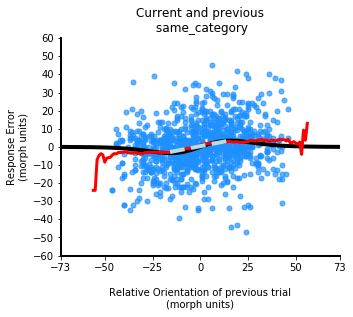

KeyboardInterrupt: 

In [7]:
empirical_amp_same_category = amplitude_calc(same_category, 'same_category')
empirical_amp_diff_category = amplitude_calc(diff_category, 'different_category')
    

In [ ]:
def slope_calc(xdata, ydata):
    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, xdata, ydata, p0=init_vals, bounds = ([-60,2],[60,4]))

    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    if x[np.argmax(y)] > 0: 
        amp = np.max(y)
    else: 
        amp = -np.max(y)
    peak_x = (x[np.argmax(y)])

    poly1d_fn, coef = getRegressionLine(x = xdata, y= ydata, peak = peak_x)

    return coef[0], amp


def init_bootstrap(xdata, ydata, nIterations=5000):
    slope_boots = []
    amp_boots = []
    bsSize = int(1.0 * len(xdata))
    iteration = 0
    while len(slope_boots) < nIterations:
#         print(iteration)
        RandIndex = np.random.choice(len(xdata), bsSize, replace=True) # get randi index of xdata
        xdataNEW = [xdata[i] for i in RandIndex] # change xdata index
        ydataNEW = [ydata[i] for i in RandIndex] # change ydata index

        try:
            slope, amp = slope_calc(xdataNEW, ydataNEW)
            slope_boots.append(slope)
            amp_boots.append(amp)
            iteration += 1
        except TypeError:
            pass       

        
    return slope_boots, amp_boots

slopes = pd.DataFrame(columns=['SUBJECT', 'TYPE', 'SLOPE'])
amps = pd.DataFrame(columns=['SUBJECT', 'TYPE', 'AMPLITUDE'])
for subject in subject_names:
    print(subject)
    tmp_same_slope = pd.DataFrame()
    tmp_diff_slope = pd.DataFrame()
    tmp_same_amp = pd.DataFrame()
    tmp_diff_amp = pd.DataFrame()
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)

    same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
    diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
    slope_same_cat, amp_same_cat = init_bootstrap(np.asarray(same_category['Stim_diff']), np.asarray(same_category['responseError']))
    slope_diff_cat, amp_diff_cat = init_bootstrap(np.asarray(diff_category['Stim_diff']), np.asarray(diff_category['responseError']))    

    tmp_same_slope['SLOPE'] = slope_same_cat
    tmp_same_slope['SUBJECT'] = subject
    tmp_same_slope['TYPE'] = 'SAME'    

    tmp_same_amp['AMPLITUDE'] = amp_same_cat
    tmp_same_amp['SUBJECT'] = subject
    tmp_same_amp['TYPE'] = 'SAME'    

    tmp_diff_slope['SLOPE'] = slope_diff_cat
    tmp_diff_slope['SUBJECT'] = subject
    tmp_diff_slope['TYPE'] = 'DIFFERENT'    

    tmp_diff_amp['AMPLITUDE'] = amp_diff_cat
    tmp_diff_amp['SUBJECT'] = subject
    tmp_diff_amp['TYPE'] = 'DIFFERENT'
    
    slopes = pd.concat([slopes, tmp_same_slope, tmp_diff_slope])
    amps = pd.concat([amps, tmp_same_amp, tmp_diff_amp])
    

In [ ]:
all_category_emp = pd.DataFrame()
all_category_emp.loc[0, 'NULL']='DIFFERENT'
all_category_emp.loc[0, 'EMPIRICAL'] = empirical_amp_diff_category
all_category_emp.loc[1, 'NULL']='SAME'
all_category_emp.loc[1, 'EMPIRICAL'] = empirical_amp_same_category

In [8]:
def init_null(data, subject, nIterations=5000):
    data_null = pd.DataFrame(columns=['ITERATION', 'SUBJECT', 'TYPE', 'AMPLITUDE', 'SLOPE'])
    row = 0
    data['Stim_diff_og'] = data['Stim_diff']
    amp_same_arr = []
    amp_diff_arr = []
    slope_same_arr = []
    slope_diff_arr = []
    for iteration in range(nIterations):
        print(iteration)
        
        data['Stim_diff'] = data['Stim_diff_og'].sample(frac=1).reset_index(drop=True)
#         data['Stim_diff'] = data['Stim_diff'].sample(frac=1).reset_index(drop=True)

        subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)

        same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
        diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
        try:

            amplitude_same = permute_null(same_category, nIterations)

#             slope_same_arr.append(slope_same)
            amp_same_arr.append(amplitude_same)
        except:
            print('')
        try:
            amplitude_diff = permute_null(diff_category, nIterations)

            amp_diff_arr.append(amplitude_diff)
#             slope_diff_arr.append(slope_diff)
        except TypeError:
            print('diff didnt converge')
        
#     return data_null
    return amp_same_arr, amp_diff_arr #, slope_same_arr, slope_diff_arr

def permute_null(data, nIterations=5000):

    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, data['Stim_diff'], data['responseError']) #, p0=init_vals,bounds = ([-60,2],[60,4]))
    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]


    if x[np.argmax(y)] > 0: 
        amplitude = np.max(y)
    else: 
        amplitude = -np.max(y)

    peak_x = (x[np.argmax(y)])

#     poly1d_fn, coef = getRegressionLine(x = data['Stim_diff'], y= data['responseError'], peak = peak_x)
    return amplitude #, coef[0]


        


# FOR PETER:

In [25]:
def init_null(data, subject, nIterations=100):
    data_null = pd.DataFrame(columns=['ITERATION', 'SUBJECT', 'TYPE', 'AMPLITUDE', 'SLOPE'])
    row = 0
    data['Stim_diff_og'] = data['Stim_diff']
    amp_same_arr = []
    amp_diff_arr = []
    slope_same_arr = []
    slope_diff_arr = []
    for iteration in range(nIterations):
        print(iteration)
        
        data['Stim_diff'] = data['Stim_diff_og'].sample(frac=1).reset_index(drop=True)

        data['same_category'] = data['stimulusID'].apply(category_definition) == data['shifted_stimulusID'].apply(category_definition)

        same_category = data[data['same_category'] == True].reset_index(drop=True)
        diff_category = data[data['same_category'] == False].reset_index(drop=True)
#         try:
            
        ## Von Mise fitting: Shape Similarity##
#             init_vals = [-25, 4]
#             print(diff_category['Stim_diff'])
#             print(diff_category['responseError'])
        best_vals, covar = curve_fit(vonmise_derivative, diff_category['Stim_diff'], diff_category['responseError']) #, p0=init_vals,bounds = ([-60,2],[60,4]))
#             print('best_vals', best_vals)
        x = np.linspace(-75, 75, 300)
        y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]


        if x[np.argmax(y)] > 0: 
            amplitude = np.max(y)
        else: 
            amplitude = -np.max(y)

        peak_x = (x[np.argmax(y)])
        print(peak_x)
        amp_diff_arr.append(amplitude)
#             print('amplitude:', amplitude)

#         except:
#             print('here')
#             pass
#         try:
        print(diff_category['Stim_diff'].values)
        print(diff_category['responseError'].values)
        poly1d_fn, coef = getRegressionLine(x = diff_category['Stim_diff'].values, y= diff_category['responseError'].values, peak = peak_x)

        slope_diff_arr.append(coef[0])
#         except:
#             print('hello')
#             pass

        
    return amp_diff_arr, slope_diff_arr #, slope_same_arr, slope_diff_arr




In [26]:
amp_nulls = pd.DataFrame()
slope_nulls = pd.DataFrame()
for subject in ['SuperSubject']:
    print(subject)
    tmp_amp_same = pd.DataFrame()
    tmp_amp_diff = pd.DataFrame()
    tmp_slope_same = pd.DataFrame()
    tmp_slope_diff = pd.DataFrame()
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_-1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
 
    amp_diff_arr, slope_diff_arr = init_null(subjectdata, subject, 10)
#     tmp_amp_same['NULL'] = amp_same_arr
#     tmp_amp_same['TYPE'] = 'SAME'
#     tmp_amp_same['SUBJECT'] = subject
    tmp_amp_diff['NULL'] = amp_diff_arr
    tmp_amp_diff['TYPE'] = 'DIFF'  
    tmp_amp_diff['SUBJECT'] = subject

    
#     tmp_slope_same['NULL'] = slope_same_arr
#     tmp_slope_same['TYPE'] = 'SAME'
#     tmp_slope_same['SUBJECT'] = subject

    tmp_slope_diff['NULL'] = slope_diff_arr
    tmp_slope_diff['TYPE'] = 'DIFF'      
    tmp_slope_diff['SUBJECT'] = subject
    
    amp_nulls = pd.concat([amp_nulls, tmp_amp_diff])
    slope_nulls = pd.concat([slope_nulls, tmp_slope_diff])

SuperSubject
0
-20.819397993311036
[-71.  12.  49. ...  71.  58.  nan]
[ 2.00097852  9.         36.         ... -5.          6.
  3.        ]


TypeError: expected non-empty vector for x

In [ ]:
ax = sns.violinplot(x='TYPE', y='AMPLITUDE', data=correct_null)
for violin, alpha in zip(ax.collections[::2], [0.2, 0.2]):
    violin.set_alpha(alpha)
    
sns.swarmplot(ax=ax, x='NULL', y='EMPIRICAL', data=all_category_emp, size=10)
plt.xlabel('')
plt.ylabel('Half Amplitude')
plt.title('Empirical vs null half amplitudes\nsame and different category')

In [ ]:
sorted_null_diff = sorted(correct_null.loc[correct_null['TYPE'] == 'DIFF', 'AMPLITUDE'])
ci97_null_diff = sorted_null_diff[int(nIterations*0.97)]
ci97_null_diff

In [ ]:
sorted_null_same = sorted(correct_null.loc[correct_null['TYPE'] == 'SAME', 'AMPLITUDE'])
ci97_null_same = sorted_null_same[int(nIterations*0.97)]
ci97_null_same

In [ ]:
sns.boxplot(correct_null[correct_null['TYPE'] == 'SAME']['AMPLITUDE'])

In [ ]:
def calc_p(data, empirical):
    p = sum(data['AMPLITUDE'] < empirical)/len(data)
    if p < .5:
        twoTailedP = p * 2;
    else:
        twoTailedP = (1 - p) * 2;
    return twoTailedP

p_same = calc_p(correct_null[correct_null['TYPE'] == 'SAME'], empirical_amp_same_category)
p_diff = calc_p(correct_null[correct_null['TYPE'] == 'DIFF'], empirical_amp_diff_category)
p_same, p_diff

#  Figure CRD

In [ ]:
good_cdf_data = cdf_data.copy()
good_cdf_data.loc[13, 'SUBJECT'] = 'mean'
good_cdf_data.loc[13, 'JND_OG'] = np.mean(good_cdf_data.loc[range(13), 'JND_OG'])
good_cdf_data.loc[13, 'JND_GAUSSIAN'] = np.mean(good_cdf_data.loc[range(13), 'JND_GAUSSIAN'])
good_cdf_data.loc[13, 'JND_CAUCHY'] = np.mean(good_cdf_data.loc[range(13), 'JND_CAUCHY'])
good_cdf_data.loc[13, 'JND_VM'] = np.mean(good_cdf_data.loc[range(13), 'JND_VM'])
good_cdf_data
jnd_vm_sem = stats.sem(good_cdf_data.loc[range(13), 'JND_VM'])
jnd_vm_sem
jnd_vm_sem_all = [0]*13
jnd_vm_sem_all.append(jnd_vm_sem)
jnd_vm_sem_all

In [ ]:
plt.figure(figsize=(13, 5))
ax = plt.bar(good_cdf_data['SUBJECT'], good_cdf_data['JND_VM'], color='lightgrey', yerr=jnd_vm_sem_all)
plt.ylabel('CRD')
plt.xticks(range(14), ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'Mean'])
sns.despine(top=True, right=True, left=False, bottom=False)


In [ ]:
# row = 0
# fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
# fig.subplots_adjust(hspace = .5, wspace=.001)
# fig.add_subplot(111, frameon=False)

# axs = axs.ravel()

# for subject in subject_names_wsuper:
subject='S1'
# load data:
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
counts, bin_edges = np.histogram(subjectdata['responseError'], bins=n_bins)
counts[counts < 5] = 0

popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) 
popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
plt.hist(subjectdata['responseError'], bins=n_bins, alpha=0.3)
plt.plot(bin_edges[1:], vm(bin_edges[1:], *popt_vm), color='green', label='vm')
plt.xlabel('')
plt.ylabel('')
plt.xlim([-60, 60])
plt.title(subject)

plt.legend()
    
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Response error on current trial\n (morph units)')
plt.ylabel('Count')
plt.title('Radiologists\n');
# plt.legend()


In [ ]:
subject='S1'
# load data:
subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
counts, bin_edges = np.histogram(subjectdata['responseError'], bins=n_bins)
cdf_vm, cdf_filtered_vm, counts_vm_filtered = cdf(counts)


bestvals_vm, temp_vm = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_vm,p0=[3])
cdf_og, cdf_filtered_og, counts_filtered_og = cdf(counts)


perc_25_vm = inverse_sigmoid(0.25, bestvals_vm)
perc_75_vm = inverse_sigmoid(0.75, bestvals_vm)    

# plt.plot(bin_edges[1:], cdf_og, color='darkgrey', linewidth=1, label='CDF')

plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_vm), color='black', linewidth=2.5)

plt.axvline(perc_25_vm, 0, 0.23, color='red', linestyle='--')
plt.axvline(perc_75_vm, 0, 0.75, color='green', linestyle='--')

low_limit = -50
plt.axhline(0.25, 0, (np.abs(low_limit) - np.abs(perc_25_vm))/100, color='red', linestyle='--')
# plt.axhline(0.75, 0, ((60 - np.abs(perc_25_vm))/100) + (perc_75_vm/100), color='green', linestyle='--')
plt.axhline(0.75, 0, ((np.abs(low_limit) + np.abs(perc_75_vm))/100), color='green', linestyle='--')

plt.xlim([low_limit, 50])
plt.ylabel('CDF')
plt.xlabel('Response Error')
# plt.legend()
# plt.title(title)
plt.show()
    

In [ ]:
row = 0
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.18)
# fig.add_subplot(111, frameon=False)

# axs = axs.ravel()

axs[0].bar(good_cdf_data['SUBJECT'], good_cdf_data['JND_VM'], color='darkgrey', yerr=jnd_vm_sem_all, edgecolor='black')
axs[0].set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '   Mean'])
axs[0].set_ylabel('CRD')
axs[0].set_xlabel('Subject')

axs[1].hist(subjectdata['responseError'], bins=n_bins, alpha=0.3, color='darkgrey', edgecolor='black')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Response error on current trial\n (morph units)')
axs[1].plot(bin_edges[1:], vm(bin_edges[1:], *popt_vm), color='green', label='Von Mises Fit', linewidth=4)
axs[1].legend()